<a href="https://colab.research.google.com/github/bindushreerd85-sketch/q1_q2/blob/main/q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1: TrainAcc 22.36%  ValAcc 32.69%  TrainLoss 2.0824
Epoch 2: TrainAcc 33.57%  ValAcc 42.73%  TrainLoss 1.8210
Epoch 3: TrainAcc 39.19%  ValAcc 49.37%  TrainLoss 1.6828
Epoch 4: TrainAcc 41.85%  ValAcc 53.87%  TrainLoss 1.6060
Epoch 5: TrainAcc 44.17%  ValAcc 53.50%  TrainLoss 1.5478
Epoch 6: TrainAcc 46.04%  ValAcc 56.21%  TrainLoss 1.5010
Epoch 7: TrainAcc 47.23%  ValAcc 56.39%  TrainLoss 1.4633
Epoch 8: TrainAcc 48.78%  ValAcc 58.09%  TrainLoss 1.4312
Epoch 9: TrainAcc 49.75%  ValAcc 59.39%  TrainLoss 1.4007
Epoch 10: TrainAcc 50.78%  ValAcc 60.80%  TrainLoss 1.3725
Epoch 11: TrainAcc 51.74%  ValAcc 60.59%  TrainLoss 1.3478
Epoch 12: TrainAcc 52.48%  ValAcc 62.41%  TrainLoss 1.3304
Epoch 13: TrainAcc 53.43%  ValAcc 62.52%  TrainLoss 1.3044
Epoch 14: TrainAcc 54.47%  ValAcc 61.52%  TrainLoss 1.2745
Epoch 15: TrainAcc 55.03%  ValAcc 63.55%  TrainLoss 1.2592
Epoch 16: TrainAcc 55.74%  ValAcc 63.83%  TrainLoss 1.2401
Epoch 17: TrainAcc 56.55%  ValAcc 66.06%  TrainLoss 1.2177
Epoch 

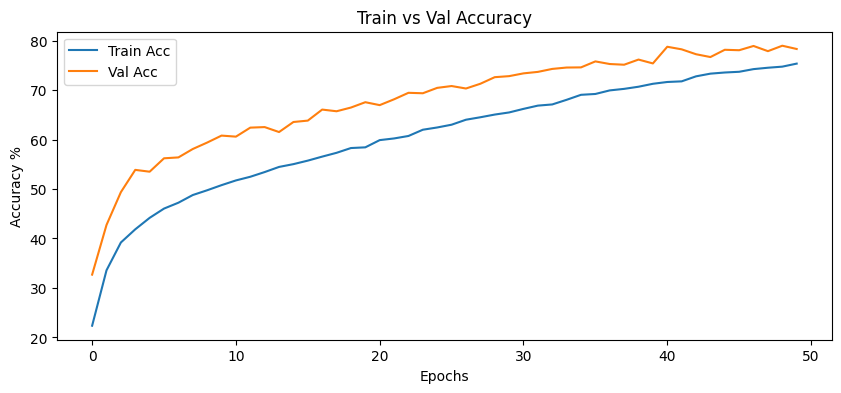

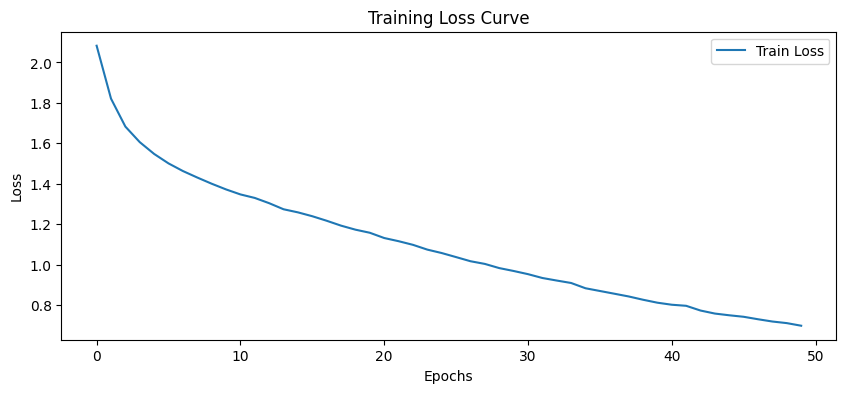

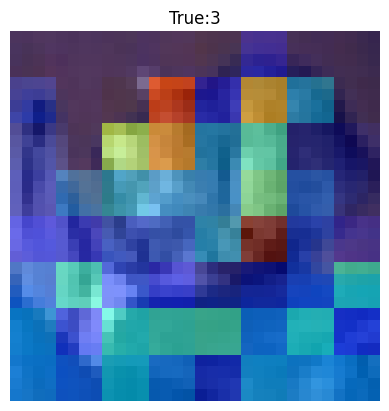

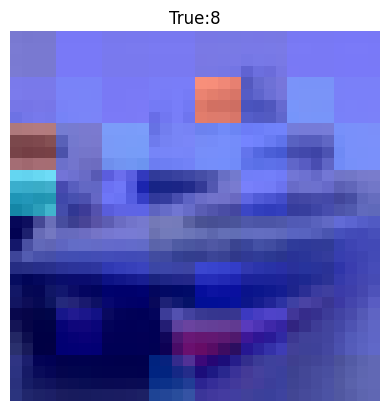

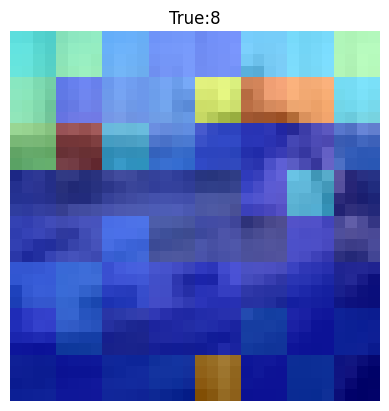

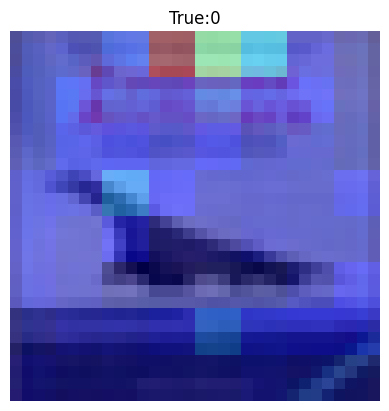

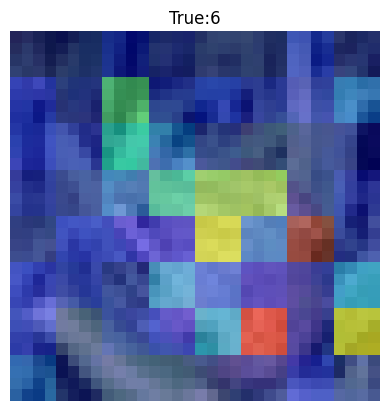

In [4]:
# import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
epochs = 50
lr = 3e-4
patch_size = 4
embed_dim = 192
depth = 8
num_heads = 6
mlp_ratio = 4.0
num_classes = 10

# Data with medium augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ViT Model
class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=192):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1,2)
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=6, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim*3)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
    def forward(self, x):
        B,N,C = x.shape
        qkv = self.qkv(x).reshape(B,N,3,self.num_heads,C//self.num_heads).permute(2,0,3,1,4)
        q,k,v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2,-1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        out = (attn @ v).transpose(1,2).reshape(B,N,C)
        out = self.proj(out)
        out = self.proj_drop(out)
        return out, attn

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim*mlp_ratio))
    def forward(self, x):
        attn_out, attn_weights = self.attn(self.norm1(x))
        x = x + attn_out
        x = x + self.mlp(self.norm2(x))
        return x, attn_weights

class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, embed_dim=192, depth=8, num_heads=6, mlp_ratio=4., num_classes=10):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, embed_dim=embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1,self.patch_embed.n_patches+1,embed_dim))
        self.blocks = nn.ModuleList([TransformerBlock(embed_dim,num_heads,mlp_ratio) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim,num_classes)
        nn.init.trunc_normal_(self.pos_embed,std=0.02)
        nn.init.trunc_normal_(self.cls_token,std=0.02)
    def forward(self, x, return_attn=False):
        x = self.patch_embed(x)
        B,N,C = x.shape
        cls_tokens = self.cls_token.expand(B,-1,-1)
        x = torch.cat((cls_tokens,x),dim=1)
        x = x + self.pos_embed
        attn_weights_all = []
        for blk in self.blocks:
            x, attn = blk(x)
            attn_weights_all.append(attn)
        x = self.norm(x)
        cls_out = x[:,0]
        if return_attn:
            return self.head(cls_out), attn_weights_all
        else:
            return self.head(cls_out)

# Training & Eval
def train_one_epoch(model, loader, optimizer, scaler=None):
    model.train()
    total, correct, loss_sum = 0,0,0
    for imgs, labels in loader:
        imgs,labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(device_type='cuda', enabled=(scaler is not None)):
            outputs = model(imgs)
            loss = F.cross_entropy(outputs, labels)
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        preds = outputs.argmax(dim=1)
        correct += (preds==labels).sum().item()
        total += labels.size(0)
        loss_sum += loss.item()*labels.size(0)
    return loss_sum/total, correct/total*100

def eval_model(model, loader):
    model.eval()
    total, correct = 0,0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs,labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            correct += (preds==labels).sum().item()
            total += labels.size(0)
    return correct/total*100

# Attention Map Visualization
def visualize_attention(model, loader, num_images=5):
    model.eval()
    images_saved = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs, attn_weights_all = model(imgs, return_attn=True)
            attn = attn_weights_all[-1]
            cls_attn = attn[:,:,0,1:]
            cls_attn_mean = cls_attn.mean(1).cpu().numpy()
            B,N = cls_attn_mean.shape
            patch_size = 32 // int(N**0.5)
            for i in range(B):
                if images_saved>=num_images: return
                attn_map = cls_attn_mean[i].reshape(int(N**0.5),int(N**0.5))
                attn_map = attn_map / attn_map.max()
                img = imgs[i].cpu().permute(1,2,0).numpy()
                img = (img-img.min())/(img.max()-img.min())
                plt.imshow(img)
                plt.imshow(np.kron(attn_map,np.ones((patch_size,patch_size))), cmap='jet', alpha=0.5)
                plt.axis('off')
                plt.title(f"True:{labels[i].item()}")
                plt.show()
                images_saved +=1

# Initialize
model = VisionTransformer(img_size=32, patch_size=patch_size, embed_dim=embed_dim,
                          depth=depth, num_heads=num_heads, mlp_ratio=mlp_ratio,
                          num_classes=num_classes).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
scaler = GradScaler() if torch.cuda.is_available() else None

# Training loop
best_val = 0
train_acc_list, val_acc_list, train_loss_list = [],[],[]
for epoch in range(1,epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler)
    val_acc = eval_model(model, test_loader)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(),'vit_cifar10_best.pth')
    print(f"Epoch {epoch}: TrainAcc {train_acc:.2f}%  ValAcc {val_acc:.2f}%  TrainLoss {train_loss:.4f}")

# Final Test Accuracy
model.load_state_dict(torch.load('vit_cifar10_best.pth'))
test_acc = eval_model(model, test_loader)
print(f"Best ValAcc: {best_val:.2f}")
print(f"Final Test Acc: {test_acc:.2f}")

# Plot Training Curves
plt.figure(figsize=(10,4))
plt.plot(train_acc_list,label='Train Acc')
plt.plot(val_acc_list,label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.legend()
plt.title('Train vs Val Accuracy')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_loss_list,label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curve')
plt.show()

# Visualize Attention Maps
visualize_attention(model,test_loader,num_images=5)


